In [18]:
import os,sys
# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and define project root accordingly
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    # Assume we are already at the project root or handle other structures as needed
    project_root = current_dir

if project_root not in sys.path:
    print(f"Adding {project_root} to sys.path")
    sys.path.append(project_root)

spk = "ava"
word = "socket"

models = {
    'Causal-RCNN': {
        'word_path': os.path.join(project_root, f"experiments/en_words_ku_causal_rcnn/causal-rcnn/case_studies/{word}_{spk}_activations.npz"),
        'phone_path': os.path.join(project_root, f"experiments/en_words_ku_causal_rcnn/causal-rcnn/case_studies/{word}_{spk}_data.npz")
    },
    '2L-BiLSTM': {
        'word_path': os.path.join(project_root, f"experiments/en_words_ku_2lstmbi/noncausal-2LSTM/case_studies/{word}_{spk}_activations.npz"),
        'phone_path': os.path.join(project_root, f"experiments/en_words_ku_2lstmbi/noncausal-2LSTM/case_studies/{word}_{spk}_data.npz")
    }
}

import numpy as np

data = {}
for name, paths in models.items():
    w_data = np.load(paths['word_path'])
    p_data = np.load(paths['phone_path'])
    
    data[name] = {
        'word_activations': w_data['cs_array'][:-10].T,
        'word_related_indices': w_data['related_indices'],
        'phoneme_activations': p_data['activations'],
        'phoneme_target_indices': p_data['target_phonemes'],
        'phoneme_list': p_data['phoneme_list'],
        'phoneme_intervals': p_data['intervals']
    }

# For convenience, keep one set of intervals for plotting setup (they should be identical for same audio)
phoneme_intervals = data['Causal-RCNN']['phoneme_intervals']
phoneme_target_indices = data['Causal-RCNN']['phoneme_target_indices']     
phoneme_phoneme_list = data['Causal-RCNN']['phoneme_list']

In [19]:
# load category dict
import pickle as pkl
cate_dict = pkl.load(open("/home/fie24002/earshot_nn/cache/category_dict_1f098615913e457060753d5042bebbdc.pkl", "rb"))

In [20]:
target_word = cate_dict[word, "Target"][0]
cohort_words = cate_dict[word, "Cohort"]
rhyme_words = cate_dict[word, "Rhyme"]
target_word, cohort_words, rhyme_words

('socket', ['sergeant', 'solid', 'solitude', 'sovereignty'], ['pocket'])

In [21]:
import pandas as pd
df = pd.read_csv("/home/fie24002/earshot_nn/dataset/words_en.csv")
target_index = df[df['word'] == target_word].index[0]
cohort_indices = df[df['word'].isin(cohort_words)].index.tolist()
rhyme_indices = df[df['word'].isin(rhyme_words)].index.tolist()
target_index, cohort_indices, rhyme_indices

(1250, [1190, 1253, 1254, 1262], [1023])

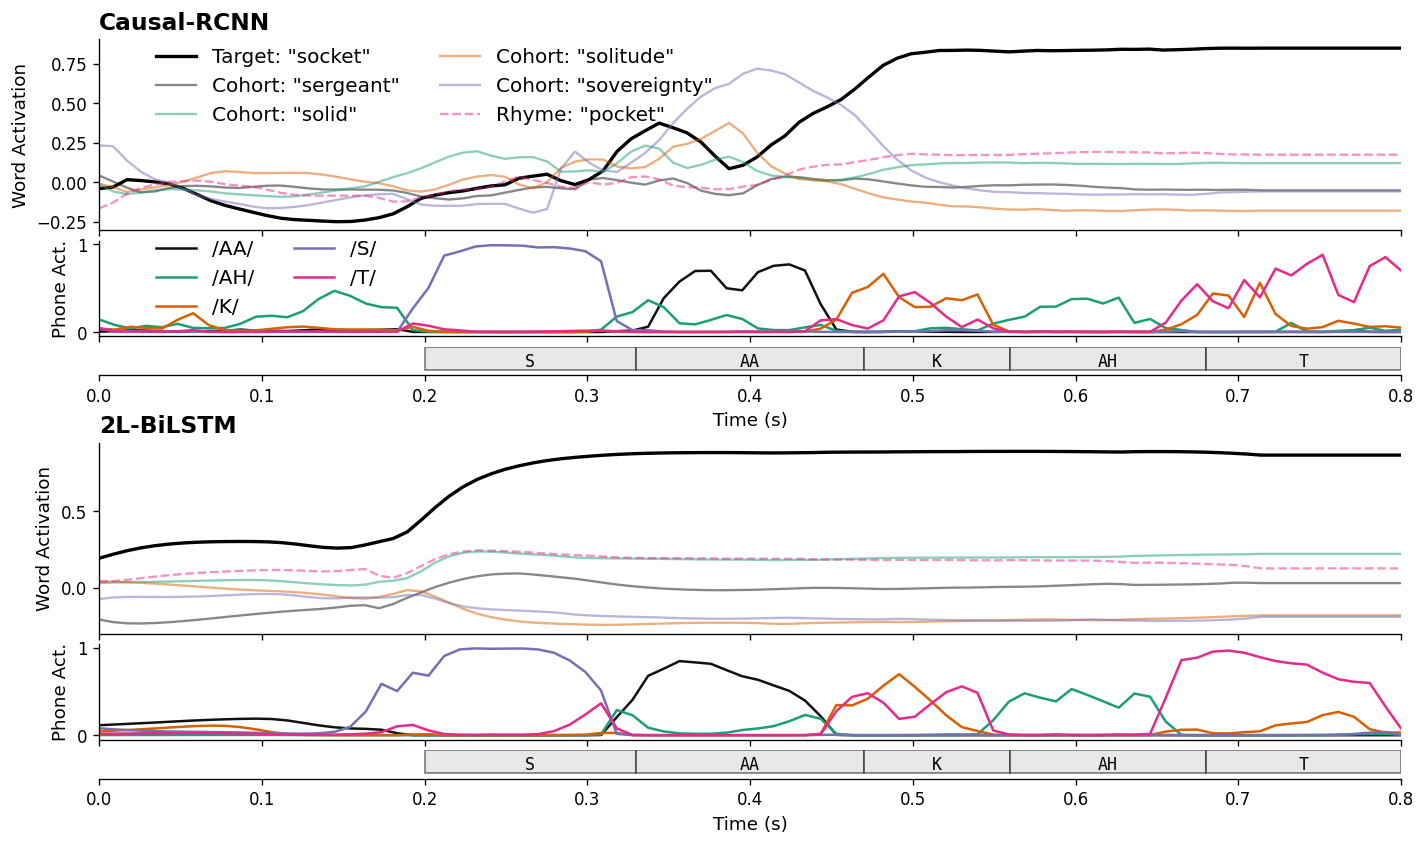

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import re

# Update figure style for publication
plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif', "legend.fontsize": 12})

# Setup figure
fig = plt.figure(figsize=(14, 8))

# Create outer GridSpec to split top and bottom models with space
outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1], hspace=0.2)

# Define model order: RCNN top, 2LSTMbi bottom
model_order = ['Causal-RCNN', '2L-BiLSTM']

# To collect handles for shared legend
word_handles_dict = {}
phoneme_handles_dict = {}

sil_shift = 0.2

# Inner height ratios for Word, Phone, Align
inner_height_ratios = [2, 1, 0.3]

axes_list = [] # Keep track of axes for shared x-axis handling if needed, though they are separate grids

for i, model_name in enumerate(model_order):
    # Create inner GridSpec for this model's 3 rows
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[i], 
                                             height_ratios=inner_height_ratios, hspace=0.1)
    
    m_data = data[model_name]
    
    # Create the 3 axes for this model
    ax_word = plt.Subplot(fig, inner[0])
    ax_phone = plt.Subplot(fig, inner[1])
    ax_align = plt.Subplot(fig, inner[2])
    
    fig.add_subplot(ax_word)
    fig.add_subplot(ax_phone)
    fig.add_subplot(ax_align)
    
    # Unpack data
    current_word_activations = m_data['word_activations']
    current_phoneme_activations = m_data['phoneme_activations']
    current_phoneme_intervals = m_data['phoneme_intervals']
    
    # Calculate time axes
    if len(current_phoneme_intervals) > 0:
        if hasattr(current_phoneme_intervals[-1], 'maxTime'):
             max_time = current_phoneme_intervals[-1].maxTime + sil_shift
        else:
             max_time = float(current_phoneme_intervals[-1][1]) + sil_shift
    else:
        max_time = 1.0
    
    max_time = min(max_time, 0.8)

    t_word = np.linspace(0, max_time, current_word_activations.shape[0])
    t_phone = np.linspace(0, max_time, current_phoneme_activations.shape[0])
    
    # Add Model Name as title to the WORD plot
    ax_word.set_title(model_name, fontsize=14, fontweight='bold', loc='left')

    # --------------------------
    # 1. Word Activations
    # --------------------------
    # Target
    l, = ax_word.plot(t_word, current_word_activations[:, target_index], label=f'Target: "{target_word}"', color='black', linewidth=2)
    word_handles_dict[f'Target: "{target_word}"'] = l

    # Cohort Individual
    if len(cohort_indices) > 0:
        for idx in cohort_indices:
            w_lbl = df.loc[idx, "word"]
            label_text = f'Cohort: "{w_lbl}"'
            l, = ax_word.plot(t_word, current_word_activations[:, idx], label=label_text, alpha=0.5)
            word_handles_dict[label_text] = l

    # Rhyme Individual
    if len(rhyme_indices) > 0:
        for idx in rhyme_indices:
            w_lbl = df.loc[idx, "word"]
            label_text = f'Rhyme: "{w_lbl}"'
            l, = ax_word.plot(t_word, current_word_activations[:, idx], label=label_text, alpha=0.5, linestyle='--')
            word_handles_dict[label_text] = l

    ax_word.set_ylabel('Word Activation')
    ax_word.spines['top'].set_visible(False)
    ax_word.spines['right'].set_visible(False)
    # Hide x labels 
    plt.setp(ax_word.get_xticklabels(), visible=False)
    ax_word.set_xlim(0, max_time) # Ensure alignment

    # --------------------------
    # 2. Phoneme Activations
    # --------------------------
    unique_phones = np.unique(m_data['phoneme_target_indices'])
    mask = (unique_phones >= 0) & (unique_phones < len(m_data['phoneme_list']))
    valid_phones = unique_phones[mask]

    for idx in valid_phones:
        ph_raw = m_data['phoneme_list'][idx]
        ph_label = re.sub(r'\d+$', '', ph_raw)
        label_text = f'/{ph_label}/'
        l, = ax_phone.plot(t_phone, current_phoneme_activations[:, idx], label=label_text, linewidth=1.5)
        phoneme_handles_dict[label_text] = l

    ax_phone.set_ylabel('Phone Act.')
    ax_phone.spines['top'].set_visible(False)
    ax_phone.spines['right'].set_visible(False)
    plt.setp(ax_phone.get_xticklabels(), visible=False)
    ax_phone.set_xlim(0, max_time)

    # --------------------------
    # 3. Phoneme Alignment (Bar)
    # --------------------------
    ax_align.axis('off')
    
    for interval in current_phoneme_intervals:
        if hasattr(interval, 'minTime'):
            start, end, label = interval.minTime, interval.maxTime, interval.mark
        else:
            start, end, label = float(interval[0]), float(interval[1]), str(interval[2])
            
        if not label.strip() or label in ['sil', 'sp']: 
            continue

        label = re.sub(r'\d+$', '', label)
        
        rect_start = start + sil_shift
        rect_width = end - start
        
        # y=0.2 to y=0.8
        rect = patches.Rectangle((rect_start, 0.2), rect_width, 0.8, 
                                 linewidth=1, edgecolor='black', facecolor='lightgray', alpha=0.5)
        ax_align.add_patch(rect)
        ax_align.text(rect_start + rect_width/2, 0.5, label, ha='center', va='center', fontsize=10, fontname='monospace')

    ax_align.set_xlim(0, max_time)
    ax_align.set_ylim(0, 1)

    ax_align.axis('on')
    ax_align.spines['top'].set_visible(False)
    ax_align.spines['right'].set_visible(False)
    ax_align.spines['left'].set_visible(False)
    ax_align.spines['bottom'].set_visible(True)
    ax_align.set_yticks([])
    ax_align.set_xlabel("Time (s)")
    
    # Store axes for legend adding later (we use the first model's axes)
    if i == 0:
        top_model_ax_word = ax_word
        top_model_ax_phone = ax_phone


# Legends - Only on the TOP panel (first model)
word_labels = list(word_handles_dict.keys())
word_handles = list(word_handles_dict.values())
top_model_ax_word.legend(word_handles, word_labels, loc='upper left', bbox_to_anchor=(0.03, 1.05), frameon=False, ncol=2)

phoneme_labels = list(phoneme_handles_dict.keys())
phoneme_handles = list(phoneme_handles_dict.values())
top_model_ax_phone.legend(phoneme_handles, phoneme_labels, loc='upper left', bbox_to_anchor=(0.03, 1.2), frameon=False, ncol=2)

# Adjust overall layout
# gridspec handles layout, so tight_layout might interfere if not careful, 
# but usually safe with subplots. Since we used GridSpec manually, we might rely on it.
# auto_layout can be true in figure defaults or we just show.
plt.show()
fig.savefig("/home/fie24002/earshot_nn/notebooks/OUT/2lstm.svg", format="svg", bbox_inches="tight")